In [7]:
from DataProcessing import Data

# 1. Get Data 

In [8]:
d = Data()
d.get_index_names()
chosen_index = 'AAPL'
d.preprocess(chosen_index)
df = d.get_data(chosen_index)
df= df.drop(['Date', 'Volume'],axis=1)
df.columns

S&P 500: ['AAPL', 'ORCL', 'GOOGL', 'AMZN', 'BK', 'LIFE', 'T', 'XOM']
 VN: ['VHM', 'CTR', 'FPT', 'MBB']
Processing AAPL.csv
Saved AAPL data at data/processed/AAPL.csv


Index(['High', 'Low', 'Close', 'RSI', 'MFI', 'EMA', 'SO', 'MACD',
       'Next Day Price'],
      dtype='object')

# 2. Train model

In [9]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import  train_test_split

In [10]:
INPUT_SHAPE=8
X = df[df.columns[0:INPUT_SHAPE]].values
Y = df[df.columns[INPUT_SHAPE]].values

## 2.1. Split data chronologically

In [11]:
TRAIN_PERCENT = 0.7
train_size = int(TRAIN_PERCENT*len(X))

X_train = X[0:train_size]
Y_train = Y[0:train_size]
X_test = X[train_size:len(X)]
Y_test = Y[train_size:len(Y)]

## 2.2. Train model

In [12]:
model = GradientBoostingRegressor()
model.fit(X_train,Y_train)
model.score(X_test,Y_test)

0.7839615075824612

## Plot Result

In [13]:
import matplotlib.pyplot as plt

In [14]:
Y_predict = model.predict(X_test)

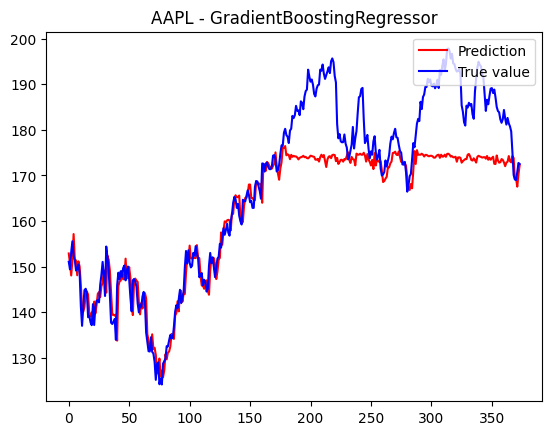

In [15]:
plt.plot(Y_predict,color='red',label='Prediction')
plt.plot(Y_test,color='blue',label='True value')
plt.legend(loc='upper right')
plt.title(f'{chosen_index} - GradientBoostingRegressor')
plt.show()